In [1]:
import numpy as np
from numba import jit, prange, njit, vectorize
#import pandas
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate as itp
import itertools as it
import warnings as w
import os 
import pylab
import math
import time
#import scripts.tools as tools
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate as itp
from scipy.optimize import curve_fit
from scipy.signal import argrelmax
#import qcodes
#import scripts.tvregdiff as tvregdiff


# Settings

In [2]:
R=0.75 #cm
H=0.2
N=500
M=200
position_of_electrons=100 

hr=R/N
hz=H/M

e=4.80324e-10
mass=9.1e-28

N_Vib=np.round(0.4/hr)
N_Vmb=np.round(0.57/hr)
N_Vob = np.round(0.7/hr)

N_Vit=N_Vib
N_Vmt=N_Vmb
N_Vot = N_Vob

x=np.linspace(0,R,N+1)
folder = "../density_profile-main/GreenFunction/"

eps=1e-9
GreenFuncName = 'Green_njit_R' + str(R).replace('.','pt') + '_H' + str(H).replace('.','pt') + '_N' + str(N) + '_M' + str(M) + '_posiE' + str(position_of_electrons) + '_epsE' + str(int(np.log10(eps))) + '.npy'


print(folder+GreenFuncName)
G = np.load(folder+GreenFuncName)

dGr = np.zeros((N, N))
dGzTOP = np.zeros((N, N))

for n in range(0, N):
    for i in range(0, N):
        # ----------- Green function difference along the charge pool ----------- #
        dGr[n,i] = -4 * np.pi * e * (G[position_of_electrons,i+1,n] - G[position_of_electrons,i,n])
        # ----------- Green function difference across the cell's top ------------# 
        dGzTOP[n, i] = -4 * np.pi * e * (G[M, i, n] - G[M-1, i, n])*(hr/hz)




../density_profile-main/GreenFunction/Green_njit_R0pt75_H0pt2_N500_M200_posiE100_epsE-9.npy


# $V_{ob}$ sweep 

## Load the saturated density functions

In [3]:
# choose the percentage such that the number of electrons trapped for Vob=0 V equals this percentage of the saturated number of electrons for Vob=0 V (either 80 or 100%)
Percentage=100

In [ ]:
Percentage

Vob with the maximum saturated electron number: 0
The number of trapped electrons is decreasing from Vob =-1
The corresponding index is: 1


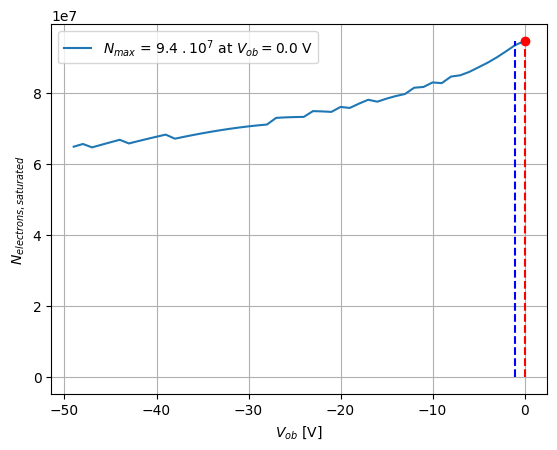

In [15]:
Vib=17
Vmb=17

# choose the same parameters as for density calculation 
# so that the loaded files do exist
# pay attention to the last voltage 
startVob = 0
endVob = -50
stepVob = -1
# Calculate the number of files (steps) to determine the colormap size
v_loop = np.arange(startVob, endVob, stepVob)
numFiles = len(v_loop)
 
# Generate a colormap
colormap = plt.jet()



column_names = ["rcm", "densitycm2"]
column_types = {"rcm": "float64", "densitycm2": "float64"}


# creates a label for each plotted line
legLabels = [None] * int(numFiles)

# Create a list to store the data for each file
DataStruct = [{} for _ in range(numFiles)]

A = np.zeros(N+1)
rdash = np.zeros(N+1)

A[0] = np.pi * np.power(hr/2, 2)
A[N] = np.pi * (N + 1 - 5/4) * np.power(hr, 2)
A[1:N] = 2 * np.pi * (np.arange(2, N+1) - 1) * np.power(hr, 2)

rdash[0:N+1] = (np.arange(0, N+1) + 1/2) * hr


folder = f"../density_profile-main/VobSweep/Vib17V_Vmb17V/PoE50percent/"

fileIndex = 0 # Initialize a counter for the file index
for v in v_loop:
    # Generate the filename
    Vob_str = f"{v:.1f}".replace(".", "p")
    # if np.abs(v) < 0.01:
    #     Vob_str = f"{-v:.1f}".replace(".", "p")

    filename = f"saturated_density_Vib{Vib}_Vmb{Vmb}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"



    file = np.load(folder+filename, allow_pickle=True)
    
    DataStruct[fileIndex] = {
        'r': file[0],
        'density': file[1],
        'Vob': v,
        'N_electrons': np.sum(A*file[1])
    }  

    fileIndex += 1 # Increment the file index


voltage = [struct['Vob'] for struct in DataStruct]
N_electrons_list = [struct['N_electrons'] for struct in DataStruct]
N_electrons_list = np.array(N_electrons_list)




# Find maximum
idx_max = np.argmax(N_electrons_list)
v_max = voltage[idx_max]
n_max = N_electrons_list[idx_max]
print('Vob with the maximum saturated electron number:', v_max)


# Find the voltage until which take the fixed number of electrons' density profiles
N_Fixed=(Percentage/100)*N_electrons_list[0]  
ind_loose_E = np.where(N_electrons_list >= N_Fixed)[0][-1]+1  # find the last index where the condition is met
v_loose_E = voltage[ind_loose_E]
print('The number of trapped electrons is decreasing from Vob ='+str(v_loose_E))
print('The corresponding index is: '+str(ind_loose_E))

# Plot
plt.plot(voltage, N_electrons_list, label=fr"$N_{{max}}$ = {(n_max*1e-7):.1f} $.10^7$ at $V_{{ob}} = {v_max:.1f}$ V")
plt.vlines(v_max, 0, n_max, color='red', linestyle='--', label='_nolegend_')  
plt.vlines(v_loose_E, 0, N_Fixed, color='blue', linestyle='--', label='_nolegend_')  # vertical line for fixed number of electrons``
plt.plot(v_max, n_max, 'ro')  # highlight the max point

plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('$N_{electrons, saturated}$')
plt.legend()
plt.grid(True)

In [ ]:
ind_loose_E

## Load the density profiles used for the calculations

<>:107: SyntaxWarning: invalid escape sequence '\e'
<>:107: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\1855955061.py:107: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')


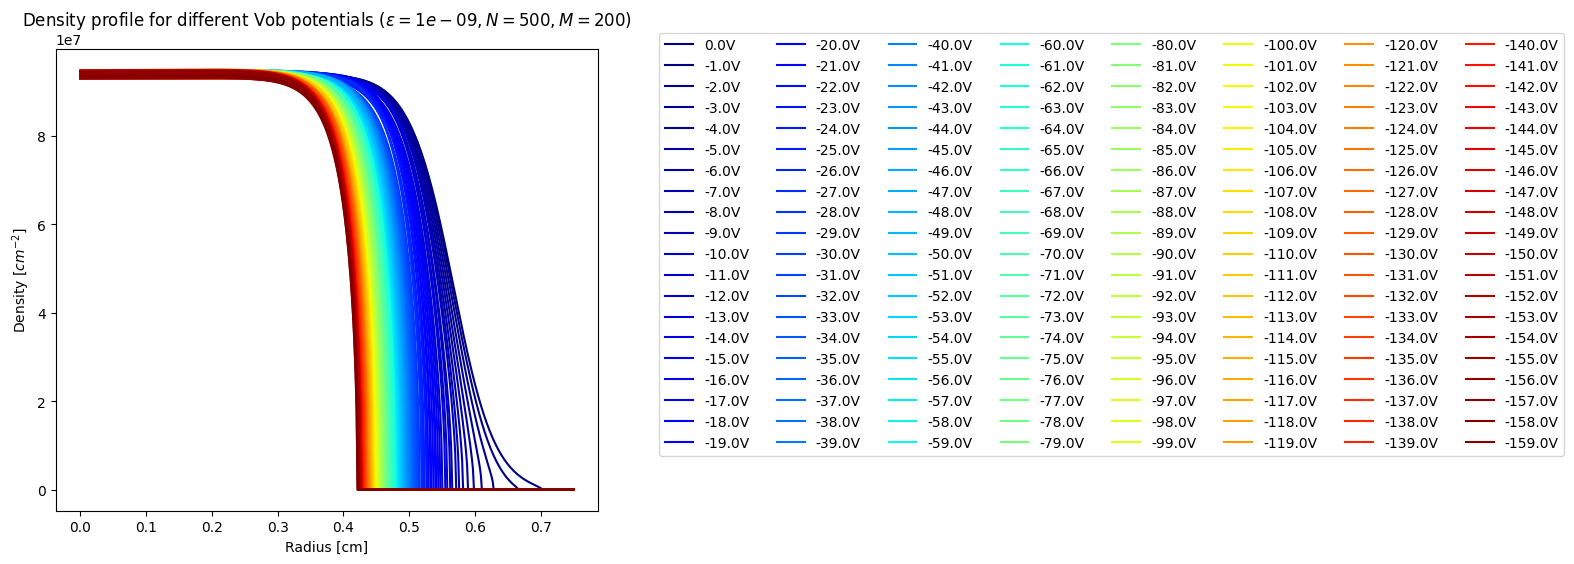

In [5]:
colors = plt.cm.jet(np.linspace(0,1,len(v_loop)))
# Loop through each file
fileIndex = 0 # Initialize a counter for the file index
fig, ax = plt.subplots(1,1, figsize=(7,6))


# Create a list to store the data for each file
DataStruct = [{} for _ in range(numFiles)]

# here we consider that the initial total number of electrons (for Vob=0V) is 0.8*Nsaturated (allows for better agreement with the experiment)
# the saturated number of electrons as a function of Vob having this profile: file saturated_number_electrons=f(Vob).png at  https://drive.google.com/drive/folders/1mCcsGUvq4owEBdB_-kIfpP9CmeoYaN83 
# and the sweep being decreasing, we neeed to use fixed N density profiles for the first 442 voltages 

# define the path to the files
# if you downloaded the folder Vmbsweep from the drive: https://drive.google.com/drive/folders/1lC1xuzMQvBS7sev4N5r9cZi6F-KcE2N-
# and that you put it in one of your folders on your desktop on Windows, the folder path should be:
# folder =f"C:/Users/username/Desktop/foldername/VobSweep/Vib17V_Vmb17V"
folder = f"../density_profile/VobSweep/Vib17V_Vmb17V/fixed_electron_number_density_{int(Percentage)}_percent_SatENum/"
folder = f"../density_profile-main/VobSweep/Vib17V_Vmb17V/PoE50percent/"
if ind_loose_E>1:
    for v in v_loop[:ind_loose_E]:
        # Generate the filename
        Vob_str = f"{v:.1f}".replace(".", "p")
        # if np.abs(v) < 0.01:
        #     Vob_str = f"{-v:.1f}".replace(".", "p")

        filename = f"fixedN_Vib{Vib}_Vmb{Vmb}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"



        file = np.load(folder+filename, allow_pickle=True)
        
        DataStruct[fileIndex] = {
            'r': file[0],
            'density': file[1],
            'Vob': v,
            'N_electrons': np.sum(A*file[1])
        }  

        # Plot density vs r using the color corresponding to the file index    
        ax.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])

        # Generate label for this line and store it
        legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vob']:.1f}V"
        fileIndex += 1 # Increment the file index

    # folder = f"../density_profile/VobSweep/Vib17V_Vmb17V/saturated_density/"


    for v in v_loop[ind_loose_E:]:
        # Generate the filename
        Vob_str = f"{v:.1f}".replace(".", "p")
        # if np.abs(v) < 0.01:
        #     Vob_str = f"{-v:.1f}".replace(".", "p")
        
        # define the path to the files
        filename = f"saturated_density_Vib{Vib}_Vmb{Vmb}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"
        file = np.load(folder+filename, allow_pickle=True)
        
        DataStruct[fileIndex] = {
            'r': file[0],
            'density': file[1],
            'Vob': v,
            'N_electrons': np.sum(A*file[1])
        }  

        # Plot density vs r using the color corresponding to the file index    
        ax.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])

        # Generate label for this line and store it
        legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vob']:.1f}V"
        fileIndex += 1 # Increment the file index

else:
    for v in v_loop:
        # Generate the filename
        Vob_str = f"{v:.1f}".replace(".", "p")
        # if np.abs(v) < 0.01:
        #     Vob_str = f"{-v:.1f}".replace(".", "p")

        filename = f"saturated_density_Vib{Vib}_Vmb{Vmb}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy"



        file = np.load(folder+filename, allow_pickle=True)
        
        DataStruct[fileIndex] = {
            'r': file[0],
            'density': file[1],
            'Vob': v,
            'N_electrons': np.sum(A*file[1])
        }  

        # Plot density vs r using the color corresponding to the file index    
        ax.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])

        # Generate label for this line and store it
        legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vob']:.1f}V"
        fileIndex += 1 # Increment the file index

    # folder = f"../density_profile/VobSweep/Vib17V_Vmb17V/saturated_density/"



ax.set_xlabel('Radius [cm]')
ax.set_ylabel('Density $[cm^{-2}]$')
ax.set_title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')
ax.legend(legLabels, ncol=8, bbox_to_anchor=(1.1, 1.05))

plt.show()



## Load Fixed

<>:40: SyntaxWarning: invalid escape sequence '\e'
<>:40: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\1511338492.py:40: SyntaxWarning: invalid escape sequence '\e'
  ax.set_title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')


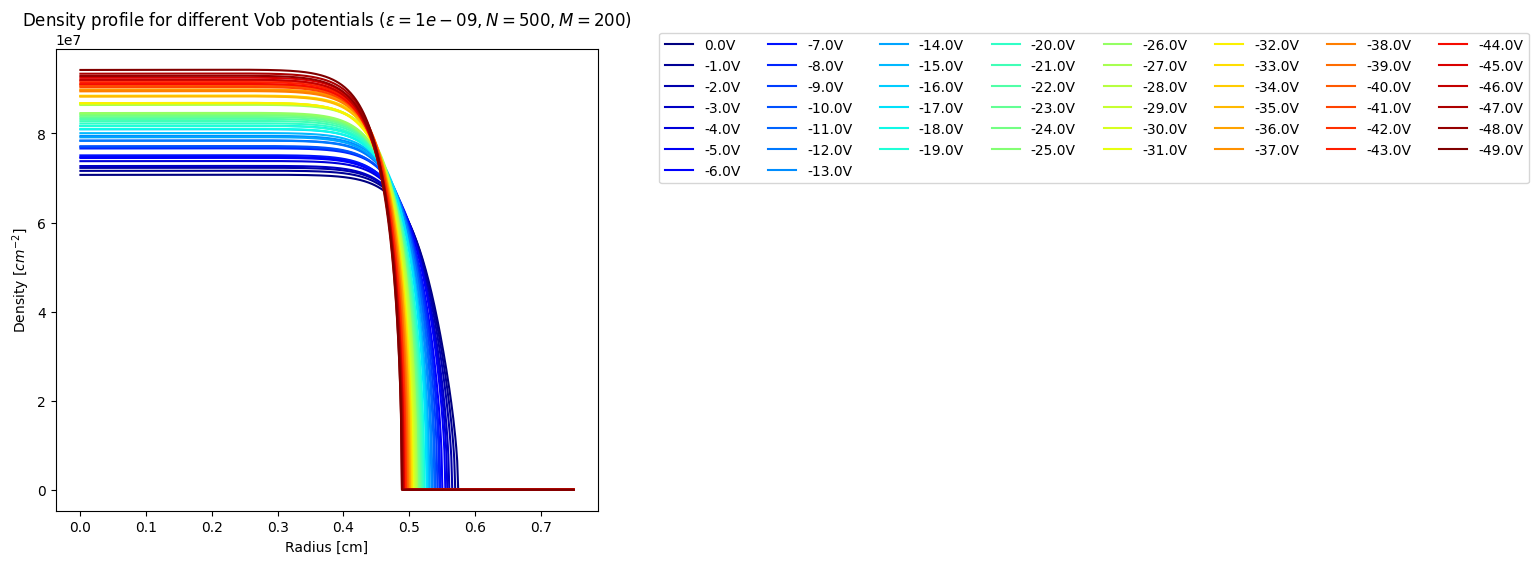

In [16]:
fixed_v = -50
colors = plt.cm.jet(np.linspace(0,1,len(v_loop)))
# Loop through each file
fileIndex = 0 # Initialize a counter for the file index
fig, ax = plt.subplots(1,1, figsize=(7,6))
# Create a list to store the data for each file
DataStruct = [{} for _ in range(numFiles)]
# here we consider that the initial total number of electrons (for Vob=0V) is 0.8*Nsaturated (allows for better agreement with the experiment)
# the saturated number of electrons as a function of Vob having this profile: file saturated_number_electrons=f(Vob).png at  https://drive.google.com/drive/folders/1mCcsGUvq4owEBdB_-kIfpP9CmeoYaN83 
# and the sweep being decreasing, we neeed to use fixed N density profiles for the first 442 voltages 
# define the path to the files
# if you downloaded the folder Vmbsweep from the drive: https://drive.google.com/drive/folders/1lC1xuzMQvBS7sev4N5r9cZi6F-KcE2N-
# and that you put it in one of your folders on your desktop on Windows, the folder path should be:
# folder =f"C:/Users/username/Desktop/foldername/VobSweep/Vib17V_Vmb17V"
folder = f"../density_profile/VobSweep/Vib{Vib}V_Vmb{Vmb}V/fixed_electron_number_density_{int(Percentage)}_percent_SatENum/"
folder = f"../density_profile-main/VobSweep/Vib{Vib}pt0V_Vmb{Vmb}pt0V/fixed_number_electrons/"
for v in v_loop:
    # Generate the filename
    Vob_str = f"{v:.1f}".replace(".", "pt")
    # if np.abs(v) < 0.01:
    #     Vob_str = f"{-v:.1f}".replace(".", "p")
    filename = f"FixedN_at{fixed_v}_Vib{Vib}_Vmb{Vmb}_Vob{Vob_str}_N{N}_M{M}_posiE{position_of_electrons}.npy".replace("-", "m")
    
    file = np.load(folder+filename, allow_pickle=True)
    
    DataStruct[fileIndex] = {
        'r': file[0],
        'density': file[1],
        'Vob': v,
        'N_electrons': np.sum(A*file[1])
    }  
    # Plot density vs r using the color corresponding to the file index    
    ax.plot(DataStruct[fileIndex]['r'], DataStruct[fileIndex]['density'], color=colors[fileIndex])
    # Generate label for this line and store it
    legLabels[fileIndex] = f"{DataStruct[fileIndex]['Vob']:.1f}V"
    fileIndex += 1 # Increment the file index
# folder = f"../density_profile/VobSweep/Vib17V_Vmb17V/saturated_density/"
ax.set_xlabel('Radius [cm]')
ax.set_ylabel('Density $[cm^{-2}]$')
ax.set_title(f'Density profile for different Vob potentials ($\epsilon={eps} ,N={N}, M={M}$)')
ax.legend(legLabels, ncol=8, bbox_to_anchor=(1.1, 1.05))
plt.show()

## Define function to calculate $\tilde \Phi$ the potential created by the AC voltage

In [6]:
iRange = np.arange(2, N+1)
# function to efficiently copy a 2D array 
@njit(parallel=True, fastmath=True)
def copyAr2D(dst, src):
    for i in prange(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i, j] = src[i, j]


fitilStart = np.full((M+1,N+1),-1/300)
fitil = np.full((M+1,N+1),-1/300)
aStart = np.zeros((M-1, N+1))
a = np.zeros((M-1, N+1))

# function to calculate the potential created by the AC voltage
def fitilSOLUT(R,H,N,M,Vib,Vmb,Vob,N_Vib,N_Vmb,Vit,Vmt,Vot,N_Vit,N_Vmt, N_Vot, N_Vob, Vr):
    np.copyto(fitil, fitilStart)


    # --------------- boundary conditions on the electrodes ----------------- #
    fitil[0, 0:int(N_Vib)] = Vib
    fitil[0, int(N_Vib):int(N_Vmb)] = Vmb
    fitil[0, int(N_Vmb):int(N_Vob)] = Vob
    fitil[0, int(N_Vob):] = Vr
        
    fitil[M, 0:int(N_Vit)] = Vit
    fitil[M, int(N_Vit):int(N_Vmt)] = Vmt
    fitil[M, int(N_Vmt):int(N_Vot)] = Vot
    fitil[M, int(N_Vot):] = Vr
    
      
    
    fitil[:, N] = Vr
    
    
    # ---------------- relaxation for homogenious solution ------------------ #
    max_err= 1
    #err = np.zeros((M+1, N+1))
    
    count = 0
    errHere = 1e-10
    print(count)
    np.copyto(a, aStart)
    while (max_err > errHere):

        count += 1
        if(count % 10000 == 0):
            print(max_err)

        np.copyto(a, fitil[1:M, 0:N+1])
        fitil[1:M, 0] = (4 * (hz/hr) * fitil[1:M, 1] + (hr/hz) * fitil[0:M-1, 0] + (hr/hz) * fitil[2:M+1, 0])/(4 * hz/hr + 2 * hr/hz)

        fitil[1:M, 1:N] = ((iRange - 1/2 - 1) * (hz/hr) * fitil[1:M, 0:N-1] + (iRange + 1/2 - 1) * (hz/hr) * fitil[1:M, 2:N+1] + (iRange-1) * (hr/hz) * fitil[0:M-1, 1:N] + (iRange-1) * (hr/hz) * fitil[2:M+1, 1:N])/(2 * (iRange-1) * (hz/hr + hr/hz))
       
        max_err = np.amax(np.abs(fitil[1:M, 0:N+1] - a))

    return fitil
    

## Calculate $\tilde \Phi$ created by the AC voltage

In [7]:
Vib_AC=0/300
Vmb_AC=0/300
Vob_AC=0/300
Vit_AC = 1/300
Vmt_AC=0/300
Vot_AC=0/300

Vr=0

phitil = fitilSOLUT(R,H,N,M,Vib_AC,Vmb_AC,Vob_AC,N_Vib,N_Vmb,Vit_AC,Vmt_AC,Vot_AC,N_Vit,N_Vmt,N_Vot, N_Vob,Vr)


Eztil = np.zeros(N+1)

Phitil = np.zeros(N+1)
Ertil = np.zeros(N)
EztilTOP = np.zeros(N)

0
2.3196415137533358e-07
9.842301381042008e-08
4.1640159470024765e-08
1.752132549812102e-08
7.349699745074628e-09
3.0786157666131547e-09
1.2884192443409631e-09
5.386847313701426e-10
2.2494479564628966e-10


## Calculate the fields and the total number of electrons

Vob with the maximum saturated electron number: -39


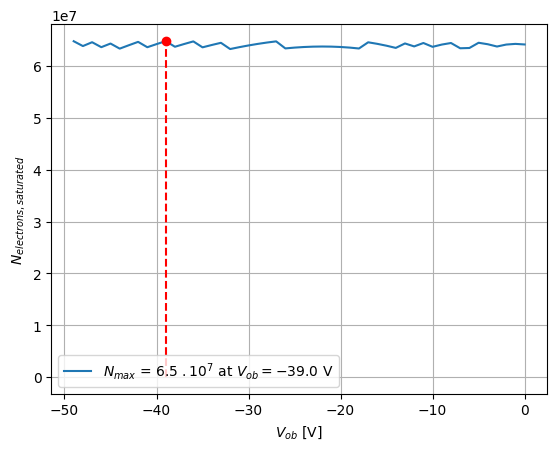

In [17]:
#-----------z component of the electric field (CGS) at the position of the electron layer (Eztil) and of the top electrode------------------#
for i in range(0, N+1):
    Eztil[i] = (phitil[position_of_electrons-1,i]-phitil[position_of_electrons,i])/hz
    Phitil[i] = phitil[position_of_electrons,i]
    

# --------- homogen. electric r-field at the el. layer (CGS) ------------ #
for i in range(0, N):
    Ertil[i] = (phitil[position_of_electrons,i]-phitil[position_of_electrons,i+1])/hr
    EztilTOP[i] = (phitil[M-1,i]-phitil[M,i])/hz

voltage = [struct['Vob'] for struct in DataStruct]


N_electrons_list = [struct['N_electrons'] for struct in DataStruct]
N_electrons_list = np.array(N_electrons_list)




# Find maximum
idx = np.argmax(N_electrons_list)
v_max = voltage[idx]
n_max = N_electrons_list[idx]
print('Vob with the maximum saturated electron number:', v_max)

# Plot
plt.plot(voltage, N_electrons_list, label=fr"$N_{{max}}$ = {(n_max*1e-7):.1f} $.10^7$ at $V_{{ob}} = {v_max:.1f}$ V")
plt.vlines(v_max, 0, n_max, color='red', linestyle='--', label='_nolegend_')  
plt.plot(v_max, n_max, 'ro')  # highlight the max point

plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('$N_{electrons, saturated}$')
plt.legend()
plt.grid(True)
    



## Calculate the plasmon frequencies and the impedance

In [34]:
omega_vector = 2 * np.pi * np.linspace(100*1e6, 140*1e6, 401)
# choose the RF frequency range for the impedance calculation
Cc=0.315083*1e-12
L=708*1e-9
C=2.130737*1e-12
Res=321.98*1e3
omegaLC = 1/np.sqrt(L*C)
omegaR=np.sqrt(C/(C+Cc))*omegaLC
fr=omegaR/(2*np.pi)
total_c_simulation = 5.2827511275046e-13 ### from capacitance matrix calculation
capacitance_ratio = total_c_simulation/C
fitted_plasmon_decay = 5e6*2*np.pi ### from frequency domain measurement
tau = 1/fitted_plasmon_decay


In [35]:
print(len(omega_vector))
fileIndex = 0


# tau obtained from the fit of the experimental data
#tau =4.039465e-8


# initialization
I_Vec = np.zeros(len(omega_vector), dtype = "complex")
I_Vec_start = np.zeros(len(omega_vector), dtype = "complex")

fileIndex = 0
deltafunc = np.eye(N+1,N+1)

E = np.zeros((N, N), dtype = "complex")
ETest = np.zeros((N, N), dtype = "complex")
D = np.zeros((N, N), dtype = "complex")
F = np.zeros((N, N), dtype = "complex")
H = np.zeros((N, N), dtype = "complex")

EStart = np.zeros((N, N), dtype = "complex")
DStart = np.zeros((N, N), dtype = "complex")

sigma = np.zeros(N, dtype = "complex")
b = np.zeros(N, dtype = "complex")

density_AC = np.zeros(N, dtype = "complex")

test1 = np.zeros((N, N), dtype = "complex")
test2 = np.zeros((N, N), dtype = "complex")

for v in v_loop:
    print(str((len(v_loop) - fileIndex))+ 'Iterations left')
    
    # ------- Find radius_of_electron_pool  -------- #  
    density=np.array(DataStruct[fileIndex]["density"])

    # hr * K = radius_of_electron_pool
    # with the notations of the calculations, K=m+1
    K = np.amin((np.nonzero(density == 0))) 
    
    np.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
    np.copyto(D[0:K, 0:K], DStart[0:K, 0:K])
    
    # -------- Calculate D----------- #
    # See Sec V-B of the calculations for the derivations of those expressions
    D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]
        

    # -------- Calculate E ----------- #
    # Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 

    E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
    for j in range(0, K):
        E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

    np.copyto(I_Vec, I_Vec_start)
    for omega_pt in range(0, len(omega_vector)):

        omega = omega_vector[omega_pt]

        # -------- Calculate sigma, the conductivity----------- #
        sigma[0:K] = np.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate F----------- #
        F=np.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate b----------- #
        b[0] = rdash[0] * sigma[0] * Ertil[0]
        b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
        b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]

        
        # -------- Calculate H----------- #
        H[0:K,0:K] = -1j * (omega * e/(2*np.pi))*D[0:K,0:K]+F[0:K,0:K]
        
        #----------Calculate the densities ie the \delta n (cf calculations) ----------- #
        density_AC[0:K] = np.dot((b[:K]),np.linalg.inv((H[:K,:K])))
        # # ------------------ use conservation of charge --------------------- #
        density_AC[K] = 0
        density_AC[K] -= np.sum(A[0:K] * (density_AC[0:K])/A[K])
        # ------------------ out of pool --------------------- #
        density_AC[K+1:N] = 0

        EzTop =-1 * np.dot(density_AC, dGzTOP)
        Q_AC=-np.sum(A[0:int(N_Vib)+1]*EzTop[0:int(N_Vib)+1]/(4*np.pi))


        I_Vec[omega_pt] = -1j * omega * capacitance_ratio * Q_AC


    diagM, V = np.linalg.eig(2*np.pi*e/mass*np.dot(E[0:K, 0:K], np.linalg.inv(D[0:K, 0:K])))
    ind = np.argsort(diagM)
    d = np.sort(diagM)

    plasmon_labels = ["First", "Second", "Third"]
    # change here the number of plasmons
    num_plasmons_to_store = 3


    for i in range(num_plasmons_to_store):
        label = plasmon_labels[i] + "Plasmon"
        DataStruct[fileIndex][label] = np.sqrt(np.real(d[i])) / (2 * np.pi * 1e6)
    DataStruct[fileIndex]['Impedance'] = np.copy(I_Vec)

    fileIndex += 1 # Increment the file   




401
50Iterations left
49Iterations left
48Iterations left
47Iterations left
46Iterations left
45Iterations left
44Iterations left
43Iterations left
42Iterations left
41Iterations left
40Iterations left
39Iterations left
38Iterations left
37Iterations left
36Iterations left
35Iterations left
34Iterations left
33Iterations left
32Iterations left
31Iterations left
30Iterations left
29Iterations left
28Iterations left
27Iterations left
26Iterations left
25Iterations left
24Iterations left
23Iterations left
22Iterations left
21Iterations left
20Iterations left
19Iterations left
18Iterations left
17Iterations left
16Iterations left
15Iterations left
14Iterations left
13Iterations left
12Iterations left
11Iterations left
10Iterations left
9Iterations left
8Iterations left
7Iterations left
6Iterations left
5Iterations left
4Iterations left
3Iterations left
2Iterations left
1Iterations left


In [36]:
# Initialize empty arrays
ImpedanceVector = []
plasmon_labels = ["First", "Second", "Third"]
num_plasmons_to_load = 3  


plasmon_vectors = {label: [] for label in plasmon_labels[:num_plasmons_to_load]}
VobVector = []

# store the data from DataStruct into vectors
for struct in DataStruct:
    VobVector.append(struct['Vob'])
    ImpedanceVector.append((struct['Impedance']))
    for label in plasmon_labels[:num_plasmons_to_load]:
        plasmon_vectors[label].append(struct[f"{label}Plasmon"])

0
1
2


<>:49: SyntaxWarning: invalid escape sequence '\e'
<>:49: SyntaxWarning: invalid escape sequence '\e'
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\2795303952.py:49: SyntaxWarning: invalid escape sequence '\e'
  plt.title('$V_{ib}=$'+str(Vib)+'$ V , V_{mb}=$'+str(Vmb)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')


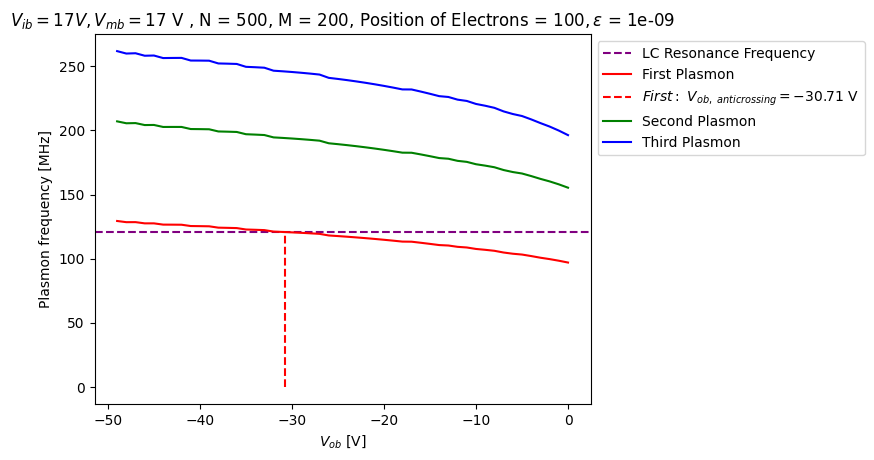

In [37]:
plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('Plasmon frequency [MHz]')

LCResonanceFrequency = 120.945
plt.axhline(y = LCResonanceFrequency, linestyle = '--', color = 'purple', label = 'LC Resonance Frequency')

# choose a color for each plot of plasmon frequencies
colors = ['r', 'g', 'b']

# Dictionnary to store splines for each plasmon
spline_plasmon = {}
spline_plot = {}

num_plasmons_to_plot = 3 

for i, name in zip(range(num_plasmons_to_plot), plasmon_labels):
    label = plasmon_labels[i]
    plt.plot(np.array(VobVector),
             plasmon_vectors[label],
             color=colors[i],
             label=f"{label} Plasmon")
    
    # convert to numpy arrays for interpolation
    VobVector = np.array(VobVector)
    plasmon_vectors[label] = np.array(plasmon_vectors[label])
    idx = np.argsort(VobVector)
    VobVector_sorted = VobVector[idx]
    plasmon_vectors_sorted = plasmon_vectors[label][idx]

    spline_plasmon[name] = itp.UnivariateSpline(
        np.array(VobVector_sorted),
        np.array(plasmon_vectors_sorted) - LCResonanceFrequency,
        s=20
    )
    print(i)

    # look for the voltages where the plasmon frequency crosses the LC resonance frequency
    if len(spline_plasmon[name].roots()>1):
        v_anti_crossing=np.round(spline_plasmon[name].roots()[0],2)
        plt.vlines(spline_plasmon[name].roots()[0], 0, LCResonanceFrequency, linestyle = '--', color=colors[i], label=rf"${name}:\ V_{{ob,\ anticrossing}} = {v_anti_crossing}\ \mathrm{{V}}$")


    spline_plot[name] = itp.UnivariateSpline(
        np.array(VobVector_sorted),
        np.array(plasmon_vectors_sorted),
        s=90
    )

plt.title('$V_{ib}=$'+str(Vib)+'$ V , V_{mb}=$'+str(Vmb)+' V , N = ' + str(N) + ', M = ' + str(M) + ', Position of Electrons = ' + str(position_of_electrons)+ f'$, \epsilon$ = {eps}', loc='center')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

## Plot the colourmap

kappa=0.3886341291731565
f_{LC}=129.58018005975157MHz
f_{R}=120.94592957478439MHz


<>:68: SyntaxWarning: invalid escape sequence '\G'
<>:84: SyntaxWarning: invalid escape sequence '\G'
<>:92: SyntaxWarning: invalid escape sequence '\G'
<>:68: SyntaxWarning: invalid escape sequence '\G'
<>:84: SyntaxWarning: invalid escape sequence '\G'
<>:92: SyntaxWarning: invalid escape sequence '\G'
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\1391868151.py:68: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Im($\Gamma$)')
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\1391868151.py:84: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='Re($\Gamma$)')
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\1391868151.py:92: SyntaxWarning: invalid escape sequence '\G'
  plt.colorbar(label='$|\Gamma|$')


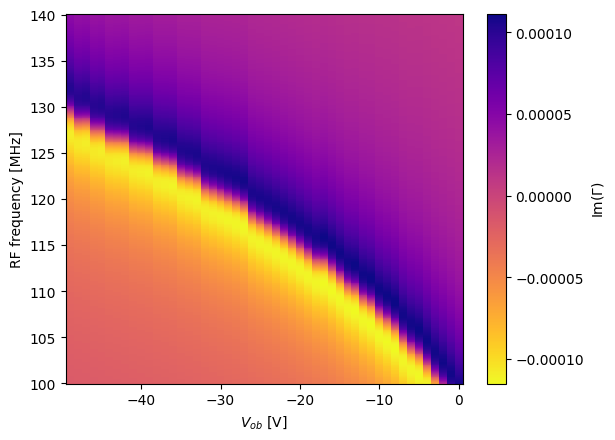

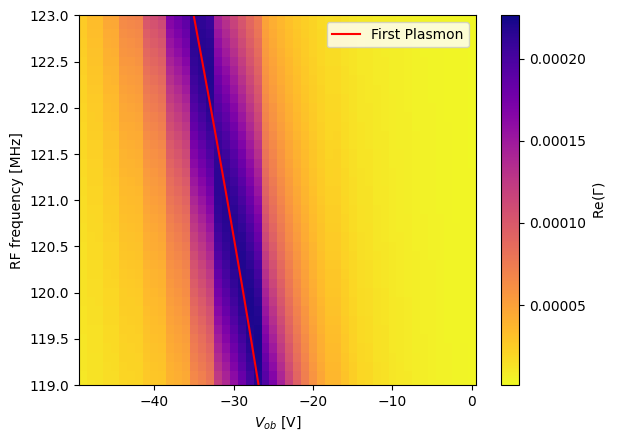

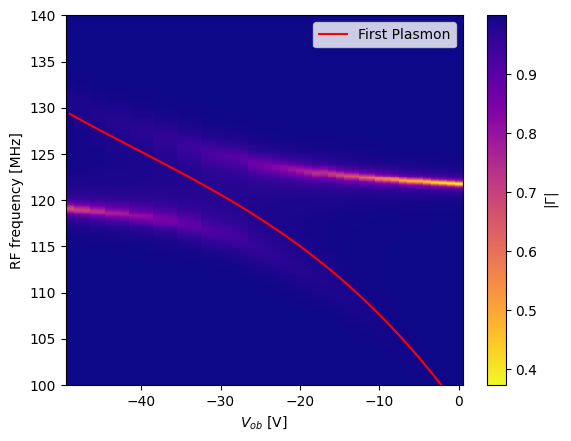

In [38]:

f_LC=omega_vector/(2*np.pi)

# creates matrices with the real and imaginary parts of the impedance
Matrix_Imag = np.zeros((len(DataStruct), len(DataStruct[0]['Impedance'])))

for i in range(0, len(DataStruct)):
    Matrix_Imag[i] = (np.imag(DataStruct[i]['Impedance']))

Matrix_Real = np.zeros((len(DataStruct), len(DataStruct[0]['Impedance'])))

for i in range(0, len(DataStruct)):
    Matrix_Real[i] = (np.real(DataStruct[i]['Impedance']))

Z0=50 

# values from the paper: https://doi.org/10.48550/arXiv.2504.09890
Cc=0.315083*1e-12
L=708*1e-9
C=2.130737*1e-12
Res=321.98*1e3
omegaLC = 1/np.sqrt(L*C)
omegaR=np.sqrt(C/(C+Cc))*omegaLC
fr=omegaR/(2*np.pi)
angular_kappa=(1/Res + ((omegaR*Cc*Z0)**2)/Z0 )/(C+Cc)
print('kappa='+str((angular_kappa/(2*np.pi))*1e-6))





print('f_{LC}='+str(1e-6*omegaLC/(2*np.pi))+'MHz') 
print('f_{R}='+str(1e-6*fr)+'MHz') 


# see Sec V of the calculations for the derivations of the formulas
Q0=omegaLC*C*Res

OneOverZp=1j * np.matrix(Matrix_Imag).T/Vit_AC/9e11 + np.matrix(Matrix_Real).T/Vit_AC/9e11

phase=-1
ZL=Res/(1+phase*1j*Q0*(omega_vector/omegaLC-omegaLC/omega_vector))


OneOverZL = np.zeros((len(DataStruct), len(ZL)), dtype = "complex")
for i in range(0, len(DataStruct)):
    OneOverZL[i] = 1/ZL


Z_L_new = 1/(np.matrix(OneOverZL).transpose() + np.matrix(OneOverZp))
# if you want to check the plot without the plasmon
# Z_L_new = 1/(np.matrix(OneOverZL).transpose() )

CouplingMatrix = np.zeros((len(DataStruct), len(omega_vector)), dtype = "complex")
for i in range(0, len(DataStruct)):
    CouplingMatrix[i] = 1/(phase*1j*omega_vector*Cc)

Z_l = np.matrix(CouplingMatrix).transpose()+ np.matrix(Z_L_new)


Gamma = (Z_l - Z0)/(Z_l + Z0)
Gamma = 1-(angular_kappa/2)*1/(angular_kappa/2-1.0j*(omega_vector-omegaR)+omegaR/(2*omega_vector*C)*np.array(OneOverZp).T)

#---------------- plot ------------------#
plasmon_labels = ["First"]
colors = ['r']

plt.pcolormesh(np.array(VobVector),omega_vector/(2*np.pi*1e6), (np.imag(OneOverZp)), shading="auto", cmap = 'plasma_r')
plt.colorbar(label='Im($\Gamma$)')
plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('RF frequency [MHz]')
plt.show()


plt.pcolormesh(np.array(VobVector), omega_vector/(2*np.pi*1e6), (np.real(OneOverZp)), shading="auto", cmap = 'plasma_r')



for color, name in zip(colors,plasmon_labels):
    plt.plot(np.array(VobVector), spline_plot[name](np.array(VobVector)), color = color, label = name+' Plasmon')

plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('RF frequency [MHz]')
plt.ylim((119, 123))  
plt.colorbar(label='Re($\Gamma$)')
plt.legend()
plt.show()



Gamma=np.asarray(Gamma)
plt.pcolormesh(np.array(VobVector), omega_vector/(2*np.pi*1e6), np.abs(Gamma.T), shading="auto", cmap = 'plasma_r')
plt.colorbar(label='$|\Gamma|$')
plt.xlabel('$V_{ob}$ [V]')
plt.ylabel('RF frequency [MHz]')

for color, name in zip(colors,plasmon_labels):
    plt.plot(np.array(VobVector), spline_plot[name](np.array(VobVector)), color = color, label = name+' Plasmon')

plt.ylim((100, 140))  
plt.legend()
plt.show()





## Calculate the modes

-30.707339040815217
-31


C:\Users\riken\AppData\Local\Temp\ipykernel_34812\2200625445.py:128: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm2 = ax2.pcolormesh(X, Y, Z,
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\2200625445.py:142: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm3 = ax3.pcolormesh(X, Y, Z_imag,
C:\Users\riken\AppData\Local\Temp\ipykernel_34812\2200625445.py:158: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explici

Second plasmon does not cross the LC resonance
Third plasmon does not cross the LC resonance


C:\Users\riken\AppData\Local\Temp\ipykernel_34812\2200625445.py:188: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_fields.legend()


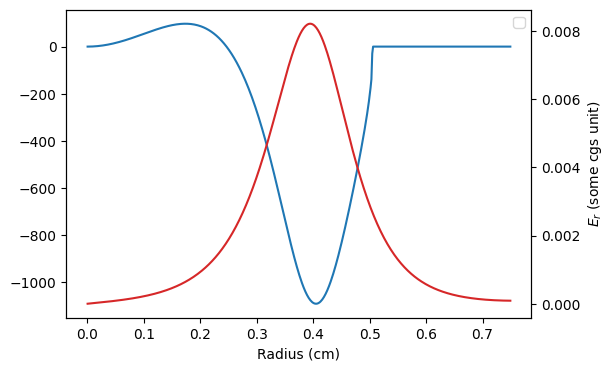

<Figure size 800x500 with 0 Axes>

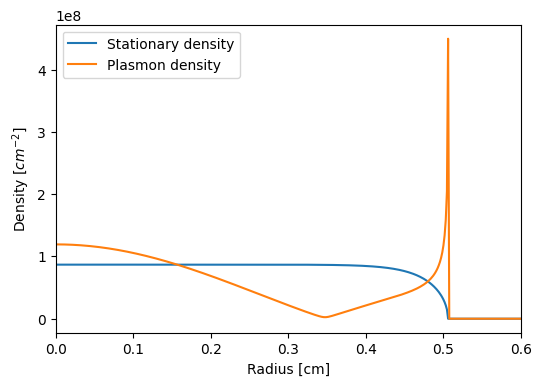

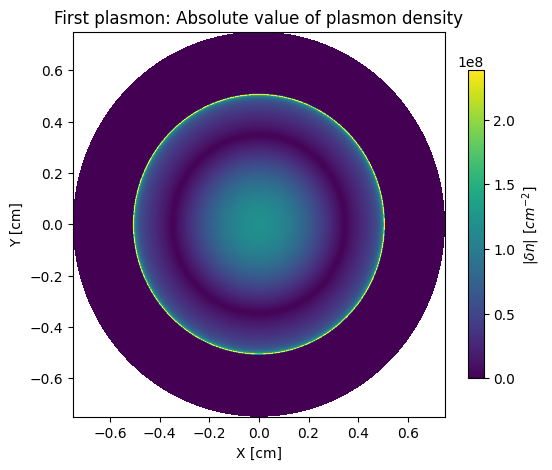

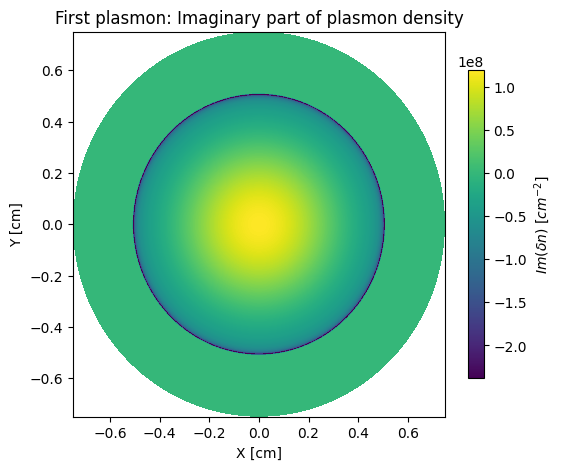

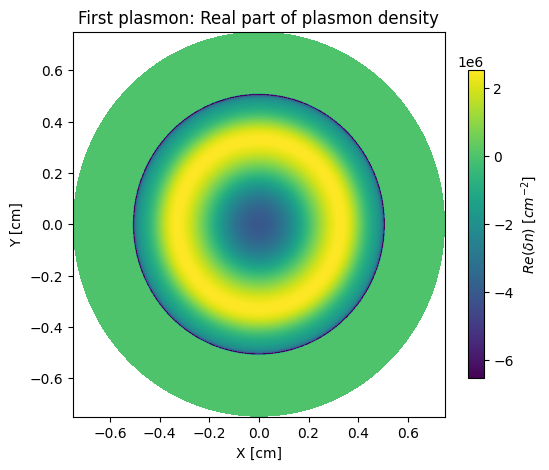

In [39]:
#import matplotlib as matplotlib
#matplotlib.use('qtagg')

from scipy.ndimage import gaussian_filter
%matplotlib inline
plasmon_labels_max = ["First", "Second", "Third", "Fourth", "Fifth", "Sixth", "Seventh", "Eigth", "Ninth"]
#print(plasmon_labels)
# change here the number of plasmons
num_plasmons_to_store = 3
plasmon_labels = plasmon_labels_max[:num_plasmons_to_store]
rdash=np.array(rdash)
#tau = 3.85363e-8

fig_fields, ax_fields = plt.subplots(1,1,figsize=(6,4))
plasmon_mode_at_anticrossing = {"tau": tau, "R (cm)": rdash[0:N], "Er_til": Ertil, "A (cm^2)": A[0:N]}
# choose the plasmon number you want to plot
# the frequency of this plasmon needs to cross the LC resonance frequency
for Plasmon_number in plasmon_labels:
    if spline_plasmon[Plasmon_number].roots().size ==0:
        print(Plasmon_number+" plasmon does not cross the LC resonance")
        continue
    else:
        plt.figure(figsize=(8, 5))

        # choose the resonance voltage
        voltage=spline_plasmon[Plasmon_number].roots()[0]
        print(voltage)

        fileIndex = np.argmin(np.abs(np.array(VobVector)-voltage))
        print(VobVector[fileIndex])
        plasmon_frequency=DataStruct[fileIndex][Plasmon_number + 'Plasmon']*2*np.pi*1e6
        omega = plasmon_frequency


        
        deltafunc = np.eye(N+1,N+1)
        E = np.zeros((N, N), dtype = "complex")
        D = np.zeros((N, N), dtype = "complex")
        F = np.zeros((N, N), dtype = "complex")
        H = np.zeros((N, N), dtype = "complex")
        sigma = np.zeros(N, dtype = "complex")
        b = np.zeros(N, dtype = "complex")
        density_AC = np.zeros(N, dtype = "complex")



        # ------- Find radius_of_electron_pool  -------- #
        density=np.array(DataStruct[fileIndex]["density"])
        # hr * K = radius_of_electron_pool
        # with the notations of the calculations, K=m+1
        K = np.amin((np.nonzero(density == 0))) 

        np.copyto(E[0:K, 0:K], EStart[0:K, 0:K])
        np.copyto(D[0:K, 0:K], DStart[0:K, 0:K])

        #  see Sec. V-B of the calculations for the derivations of those expressions
        # -------- Calculate D ----------- #
        D[0:K,0:K]=deltafunc[0:K,0:K]*A[0:K]



        # -------- Calculate E ----------- #
        # Only the coefficients in positions [0:K, 0:K] of the matrices E, D and F are used for the calculations of the modes 
        E[0:K, 0] = -1 * rdash[0]*density[0]*(dGr[K,0]*A[0:K]/A[K]- dGr[0:K,0])
        for j in range(0, K):
            E[j,1:K] = -1 * rdash[1:K]*density[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

        # -------- Calculate sigma, the conductivity----------- #

        sigma[0:K] = np.power(e, 2) * density[0:K] * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate F  ----------- #
        F=np.power(e, 2) * E * tau/(mass * (1 - 1j * omega * tau))

        # -------- Calculate b----------- #
        b[0] = rdash[0] * sigma[0] * Ertil[0]
        b[K-1] = -1 * rdash[K-2]*sigma[K-2]*Ertil[K-2]
        b[1:K-1] = rdash[1:K-1] * sigma[1:K-1] * Ertil[1:K-1] - rdash[0:K-2] * sigma[0:K-2] * Ertil[0:K-2]

            
        # -------- Calculate H----------- #
        H[0:K,0:K] = -1j * (omega * e/(2*np.pi))*D[0:K,0:K]+F[0:K,0:K]
            
        #----------Calculate the densities ie the \delta n  ----------- #
        density_AC[0:K] = np.dot((b[:K]),np.linalg.inv((H[:K,:K])))

        # # ------------------ use conservation of charge --------------------- #
        density_AC[K] -= np.sum(A[0:K] * (density_AC[0:K])/A[K])
        # ------------------ out of the pool --------------------- #
        density_AC[K+1:N] = 0
        
        ErPool =-1 * np.dot(density_AC, dGr)
        current_density =   sigma *  ErPool
        ax_fields.plot(rdash[0:N], np.imag(current_density*A[0:N]))

        theta = np.linspace(0, 4 * np.pi, 10000)
        R_plot, Theta = np.meshgrid(rdash[0:N], theta)


        X = R_plot * np.cos(Theta)
        Y = R_plot * np.sin(Theta)


        Z = np.tile(np.abs(density_AC[0:N]), (len(theta), 1))
        Z_real= np.tile(np.real(density_AC[0:N]), (len(theta), 1))
        Z_imag= np.tile(np.imag(density_AC[0:N]), (len(theta), 1))



        Z = gaussian_filter(Z, sigma=1)
        Z_real = gaussian_filter(Z_real, sigma=1)
        Z_imag = gaussian_filter(Z_imag, sigma=1)   

        # 2D plot of the densities 
        fig1, ax1 = plt.subplots(figsize=(6,4))
        ax1.plot(rdash[0:N], density[0:N],      label='Stationary density')
        ax1.plot(rdash[0:N], np.abs(density_AC[0:N]), label='Plasmon density')
        ax1.set_xlim(0, 0.6)
        ax1.set_xlabel('Radius [cm]')
        ax1.set_ylabel('Density $[cm^{-2}]$')
        ax1.legend()
        plt.draw()



        # 3D plot of the absolute value of the plasmon density
        fig2, ax2 = plt.subplots(figsize=(6,5))
        pcm2 = ax2.pcolormesh(X, Y, Z,
                            shading='nearest',
                            cmap='viridis')
        ax2.set_title(f'{Plasmon_number} plasmon: Absolute value of plasmon density')
        ax2.set_xlabel('X [cm]')
        ax2.set_ylabel('Y [cm]')
        fig2.colorbar(pcm2,
                    ax=ax2,
                    shrink=0.8,
                    label=r'$|\delta n|\ [cm^{-2}]$')
        plt.draw()

        # 3D plot of the imaginary part of the plasmon density
        fig3, ax3 = plt.subplots(figsize=(6,5))
        pcm3 = ax3.pcolormesh(X, Y, Z_imag,
                            shading='nearest',
                            cmap='viridis')
        ax3.set_title(f'{Plasmon_number} plasmon: Imaginary part of plasmon density')
        ax3.set_xlabel('X [cm]')
        ax3.set_ylabel('Y [cm]')
        fig3.colorbar(pcm3,
                    ax=ax3,
                    shrink=0.8,
                    label=r'$Im(\delta n)\ [cm^{-2}]$')
        plt.draw()



        # 3D plot of the real part of the plasmon density
        fig4, ax4 = plt.subplots(figsize=(6,5))
        pcm4 = ax4.pcolormesh(X, Y, Z_real,
                            shading='nearest',
                            cmap='viridis')
        ax4.set_title(f'{Plasmon_number} plasmon: Real part of plasmon density')
        ax4.set_xlabel('X [cm]')
        ax4.set_ylabel('Y [cm]')
        fig4.colorbar(pcm4,
                    ax=ax4,
                    shrink=0.8,
                    label=r'$Re(\delta n)\ [cm^{-2}]$')
        plt.draw()

        E_AC = np.zeros((N, N), dtype = "complex")
        E_AC[0:K, 0] = -1 * rdash[0]*density_AC[0]*(dGr[K,0]*A[0:K]/A[K]-dGr[0:K,0])
        for j in range(0, K):
            E_AC[j,1:K] = -1 * rdash[1:K]*density_AC[1:K]*(dGr[K,1:K]*A[j]/A[K]-dGr[j,1:K])+rdash[0:K-1]*density_AC[0:K-1]*(dGr[K,0:K-1]*A[j]/A[K]-dGr[j,0:K-1])

        Er_AC = np.zeros(E_AC.shape[0], dtype=complex)


        for i in range(len(Er_AC)):
            Er_AC[i] = np.sum(np.abs(E_AC[i]))
            
        plasmon_mode_at_anticrossing[Plasmon_number] = {"AC Density": density_AC, "Current Density ": current_density, "Er_electrons": ErPool}
        #plt.plot(Er1)

ax_fields_tilde = ax_fields.twinx()
ax_fields_tilde.plot(rdash[0:N], Ertil, "C3", label="tilde")
ax_fields.set_xlabel("Radius (cm)")
ax_fields_tilde.set_ylabel("$E_r$ (some cgs unit)")
ax_fields.legend()
plt.draw_all()

In [ ]:
DataStruct

# Save Modes and Frequencies

In [40]:
import pickle

def pickle_save(filename, data):
    with open(filename, 'wb') as fp:
        pickle.dump(data, fp, protocol=pickle.HIGHEST_PROTOCOL)
def pickle_load(filename):
    with open(filename, 'rb') as fp:
        data = pickle.load(fp)
    return data
RT = 0.75
dict_to_save = {"Plasmon Frequencies": {}, "Impedance": {"FrequencyLC": omega_vector, "Gamma": Gamma}, "MetaData": {"N": N, "M": M, "Vib": Vib, "Vmb": Vmb, "R": R, "Percentage": 100},
                "Modes": plasmon_mode_at_anticrossing}
dict_to_save["Plasmon Frequencies"]["Vob"] = VobVector
plasmon_labels = plasmon_labels_max[:num_plasmons_to_store]
for i in range(num_plasmons_to_store):
    print(i)
    dict_to_save["Plasmon Frequencies"]["Plasmon %i"%(i+1)] = plasmon_vectors[plasmon_labels[i]]
fileName = f"Plasmon_Summary_Vib{Vib}_Vmb{Vmb}_N{N}_M{M}_R{RT}_posiE{position_of_electrons}_percent{100}_cap_correction_fixed".replace(".", "pt")
pickle_save(fileName+".npy", dict_to_save)






0
1
2
